In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from sklearn.preprocessing import robust_scale
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from tabulate import tabulate
from sklearn.decomposition import PCA
from ddot import Ontology

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
sns.set()
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size":8, "ytick.major.size":8})
sns.axes_style("whitegrid")
sns.set_palette("muted")
sns.color_palette("muted")

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

In [3]:
plt.rcParams['svg.fonttype'] = 'none'

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [4]:
#Separating data for each drug/cell

def get_pos_map(obj_list, test_df, col):
    pos_map = {obj:[] for obj in obj_list}
    for i, row in test_df.iterrows():
        if row[col] in pos_map:
            pos_map[row[col]].append(i)
    return pos_map

In [5]:
#Arrange the obj_list in the descending order of the scores

def sort_scores(obj_list, scores):
    score_map = {}
    for i, obj in enumerate(obj_list):
        score_map[obj] = scores[i]
    return {obj:sc for obj,sc in sorted(score_map.items(), key=lambda item:item[1], reverse=True)}

In [6]:
def conf_interval(ratio, std_error):
    """
    Calculate 95% confidence interval for odds ratio and relative risk.
    """

    _lci = np.log(ratio) - 1.96*std_error
    _uci = np.log(ratio) + 1.96*std_error

    lci = round(np.exp(_lci), 2)
    uci = round(np.exp(_uci), 2)

    return (lci, uci)

In [7]:
def create_confusion_matrix(sens, res, pred_sens, pred_res):
    tp = len([c for c in pred_sens if c in sens]) + 1
    fn = len([c for c in pred_sens if c in res]) + 1
    fp = len([c for c in pred_res if c in sens]) + 1
    tn = len([c for c in pred_res if c in res]) + 1
    
    conf_table = [['Sensitive', tp-1, fn-1],
                  ['Resistant', fp-1, tn-1]]
    odds_ratio = (tp*tn)/(fn*fp)
    std_err = np.sqrt((1/tp)+(1/fn)+(1/fp)+(1/tn))
    ci = conf_interval(odds_ratio, std_err)
    
    return conf_table, odds_ratio, ci

In [8]:
def create_true_auc_waterfall(test_df, sens_df, res_df, pred_sens_df, pred_res_df, title):
    
    fig, ax = plt.subplots(figsize=(8, 8))

    data_list = []
    test_df.sort_values(by='auc', inplace=True, ignore_index=True, ascending=False)
    for _,row in test_df.iterrows():
        cell_name = str(row['cell_line'])
        
        if cell_name not in list(res_df['cell_line']) and cell_name not in list(sens_df['cell_line']):
            continue
        
        if cell_name in list(pred_res_df['cell_line']):
            data_list.append((cell_name, row['auc'], 'goldenrod'))

        if cell_name in list(pred_sens_df['cell_line']):
            data_list.append((cell_name, row['auc'], 'royalblue'))
            
    ax.bar([d[0] for d in data_list], [d[1] for d in data_list], color=[d[2] for d in data_list], width=1, edgecolor='none')
    ax.set_xticks([])
    ax.set_ylim((0, np.max(test_df['auc']) + 0.02))
    ax.set_xlabel('Cell lines')
    ax.set_ylabel('True AUC')
    ax.set_title(title)
    return fig

In [9]:
def plot_drug_performance(drug_corr_map, cut_off):
    fig, ax = plt.subplots(figsize=(8, 8))
    x_red = []
    y_red = []
    x_blue = []
    y_blue = []
    for d in drug_corr_map.keys():
        if drug_corr_map[d] >= cut_off:
            x_red.append(d)
            y_red.append(drug_corr_map[d])
        else:
            x_blue.append(d)
            y_blue.append(drug_corr_map[d])
    
    ratio = float(len(x_red))/float(len(drug_corr_map.keys()))
    print('Red ratio = ' + str(ratio))
    ax.bar(x_red, y_red, color='red', width=1.0, alpha=0.9)
    ax.bar(x_blue, y_blue, color='blue', width=1.0, alpha=0.9)
    ax.set_xticks([])
    ax.set_xlabel('Drugs')
    ax.set_ylabel('Performance\nSpearman ρ (Predicted vs. Actual)')
    plt.show()
    return fig

In [10]:
def create_drug_performance_plot(drugs, drug_corr_list, top=False, cut_off=0.1):
    drug_corr_map = sort_scores(drugs, drug_corr_list)
    if top:
        fig_drug_perf = plot_top_drug_performance(drug_corr_map, cut_off)
    else:
        fig_drug_perf = plot_drug_performance(drug_corr_map, cut_off)
        print('Median spearman rho:', np.median(list(drug_corr_map.values())))
    return fig_drug_perf

In [11]:
def create_scatter_plot(X, Y, x_title, y_title):
    
    idx_del = []
    for i, x in enumerate(X):
        if math.isnan(x):
            idx_del.append(i)
    for i, y in enumerate(Y):
        if math.isnan(y):
            idx_del.append(i)
    X = [x for i, x in enumerate(X) if i not in idx_del]
    Y = [y for i, y in enumerate(Y) if i not in idx_del]
    
    scatter_df = pd.DataFrame({x_title: X, y_title: Y})
    
    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(data=scatter_df, x=x_title, y=y_title, s=35, ax=ax)
    
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    print('t-test', stats.ttest_ind(Y, X, alternative='greater', equal_var=False))
    
    return fig

In [12]:
def get_boxplot(df, x_title, y_title):
    
    fig, ax = plt.subplots(figsize=(9,9))
    ax.boxplot(df, showfliers=False, widths=0.5, patch_artist=True)
    #ax.set_xticklabels(list(df.columns))
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    
    plt.show()
    
    return fig

In [13]:
def create_bar_chart(x, data, x_title, y_title):
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111)
    x_pos = [i for i, _ in enumerate(x)]
    x_labels = [s for _,s in enumerate(x)]
    ax.bar(x_pos, data, align='center', alpha=1.0)
    plt.xticks(x_pos, x)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [14]:
def create_bar_chart_with_errors(x, data, errors, x_title, y_title):
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111)
    x_pos = [i for i, _ in enumerate(x)]
    x_labels = [s for _,s in enumerate(x)]
    ax.bar(x_pos, data, align='center', alpha=1.0)
    ax.errorbar(x_pos, data, yerr=errors, fmt='o', color='r', capsize=10)
    plt.xticks(x_pos, x)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [15]:
def create_histogram(data, x_title, y_title):
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111)
    ax.hist(x=data, bins='auto', alpha=0.7, rwidth=0.85)
    ax.grid(False)
    #ax.set_xlim(0, 1)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [16]:
def get_violinplot(df, x_title, y_title):
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.violinplot(df, showmedians=True)
    ax.set_xticklabels(list(df.columns), rotation=45)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    
    plt.show()
    
    return fig

In [17]:
def create_line_curve(X, Y, x_title, y_title, x_lim, y_lim):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.plot(X, Y)
    ax.grid(False)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    plt.show()
    return fig

In [40]:
def all_models_scatterplot(performance_df, x_title, y_title):
    
    fig, ax = plt.subplots(figsize=(5, 8))
    
    performance_df.plot(kind='scatter', x='Multi-task VNN', y='Drug', color='red', label='Multi-task VNN', s=30, ax=ax)
    performance_df.plot(kind='scatter', x='Single-task VNN', y='Drug', color='Blue', label='Single-task VNN', ax=ax)
    #performance_df.plot(kind='scatter', x='Random Forest', y='Drug', color='DarkGreen', label='Random Forest', ax=ax)
    performance_df.plot(kind='scatter', x='ANN', y='Drug', color='Green', label='ANN (matched Black box)', ax=ax)
    #performance_df.plot(kind='scatter', x='ElasticNet', y='Drug', color='LightGreen', label='ElasticNet', ax=ax)
    
    ax.axvline(x=1, color='black', linestyle='--')
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    return fig

In [19]:
def get_all_test(method, parent_dir, ont, dataset, drug, zscore_method='auc', fold_size=5):
    
    all_test = []
    for i in range(1, fold_size+1):
        
        test_file = '../../dcodr/data/training_files_' + dataset + '/' + str(i) + '_test_' + dataset + '_' + drug + '.txt'
        test_df = pd.read_csv(test_file, sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
        
        if method == None:
            modeldir = '../../dcodr/' + parent_dir + '/model_' + ont + '_' + dataset + '_' + drug + '_' + zscore_method + '_' + str(i) 
            pred_file = modeldir + '/predict.txt'
        else:
            modeldir = '../../dcodr/models/' + method
            pred_file = modeldir + '/predict' + '_' + dataset + '_' + drug + '_' + str(i) + '.txt'
        try:
            pred = np.loadtxt(pred_file)
        except:
            continue
        test_df['pred'] = pred
        all_test.append(test_df)
    
    all_test_df = pd.concat(all_test, axis=0, ignore_index=True)
    
    cell_name_map = dict()
    for i, row in all_test_df.iterrows():
        cell_line_name = str(row['cell_line'])
        if cell_line_name not in cell_name_map:
            cell_name_map[cell_line_name] = 1
        else:
            all_test_df.drop(i, inplace=True)
    all_test_df = all_test_df.reset_index(drop=True)
    return all_test_df

In [20]:
def stratify_data(test_df, col):
    
    sens_samples = []
    res_samples = []
    median = np.median(np.array(test_df[col]))
    std_dev = np.std(np.array(test_df[col]))
    t_low = median - std_dev
    t_high = median + std_dev
        
    sens_df = test_df.query("{0} <= @t_low".format(col))[['cell_line', 'auc', 'pred']]
    res_df = test_df.query("{0} >= @t_high".format(col))[['cell_line', 'auc', 'pred']]
        
    return sens_df, res_df

In [21]:
def get_filtered_data(test_df):

    auc = test_df['auc']
    auc_thr1 = np.percentile(auc, 25)
    auc_thr2 = np.percentile(auc, 75)
    sens_df = test_df.query('auc <= @auc_thr1')[['cell_line', 'auc', 'pred']]
    res_df = test_df.query('auc >= @auc_thr2')[['cell_line', 'auc', 'pred']]
    
    #sens_df, res_df = stratify_data(test_df, 'auc')
    
    for i, row in test_df.iterrows():
        if str(row['cell_line']) not in list(sens_df['cell_line']) and str(row['cell_line']) not in list(res_df['cell_line']):
            test_df.drop(i, inplace=True)
    
    pred = test_df['pred']
    pred_thr1 = np.percentile(pred, 50)
    pred_thr2 = np.percentile(pred, 50)
    pred_sens_df = test_df.query('pred <= @pred_thr1')[['cell_line', 'auc', 'pred']]
    pred_res_df = test_df.query('pred >= @pred_thr2')[['cell_line', 'auc', 'pred']]
    
    #pred_sens_df, pred_res_df = stratify_data(test_df, 'pred')
    
    return sens_df, res_df, pred_sens_df, pred_res_df

In [22]:
def get_odds_ratio_mtl(parent_dir, ont, dataset, task, drugs, drug_name_map, fold_size=5):
    
    all_test = []
    for f in range(1, fold_size+1):
        modeldir = '../' + parent_dir + '/model_' + ont + '_' + dataset + '_' + task + '_' + str(f)
        test_df = pd.read_csv(modeldir + '/test.txt', sep='\t')
        pred_file = modeldir + '/predict.txt'
        pred =  np.loadtxt(pred_file)
        pred_test_df = pd.concat([test_df, pd.DataFrame(pred)], axis=1)
        all_test.append(pred_test_df)
    all_test_df = pd.concat(all_test, axis=0, ignore_index=True)
        
    result = []
    for i,d in enumerate(drugs):
        drug_test_df = all_test_df[['cell_line', d, i]].copy()
        drug_test_df.rename(columns={d:'auc', i:'pred'}, inplace=True)
        drug_test_df = drug_test_df.dropna().reset_index(drop=True)
        
        sens_df, res_df, pred_sens_df, pred_res_df = get_filtered_data(drug_test_df)
        #waterfall_fig = create_true_auc_waterfall(drug_test_df, sens_df, res_df, pred_sens_df, pred_res_df, drug_name_map[d])
        #waterfall_fig.savefig('../plots/' + drug_name_map[d] + '_waterfall.svg')
        
        cont_table, odds_ratio, ci = create_confusion_matrix(list(sens_df['cell_line']), list(res_df['cell_line']), 
                                                     list(pred_sens_df['cell_line']), list(pred_res_df['cell_line']))
        xerr = odds_ratio - ci[0], ci[1] - odds_ratio
        result.append((odds_ratio, drug_name_map[d], xerr))
        
        print(drug_name_map[d])
        print(tabulate(cont_table, headers=['', 'True Sensitive', 'True Resistant'], tablefmt='grid'))
        print('Odds Ratio: ', odds_ratio)
        print('CI: ', ci)
        
    result.sort(key=lambda x: x[0])
    fig, ax = plt.subplots(figsize=(8, 12))
    ax.errorbar([r[0] for r in result], [r[1] for r in result], xerr=np.transpose(np.array([r[2] for r in result])), fmt="o", color='black', capsize=5)
    ax.axvline(x=1, color='black', linestyle='--')
    ax.set_xlabel('Odds Ratio')
    ax.set_xticks([0,1,2,3,4,5,6])
    
    return result, fig

In [23]:
def get_avg_cv_data_mtl(parent_dir, ont, dataset, task, drugs, fold_size=5):
    
    corr_list = []
    for f in range(1, fold_size+1):
        modeldir = '../' + parent_dir + '/model_' + ont + '_' + dataset + '_' + task + '_' + str(f)
        test_df = pd.read_csv(modeldir + '/test.txt', sep='\t')
        pred_file = modeldir + '/predict.txt'
        pred =  np.loadtxt(pred_file)
        
        fold_corr = []
        for i,d in enumerate(drugs):
            xi = np.array(test_df[d])
            yi = pred[:,i]
            mask = np.isnan(xi)
            xi = xi[~mask]
            yi = yi[~mask]
            fold_corr.append(stats.pearsonr(xi, yi)[0])
        corr_list.append(fold_corr)
    
    return corr_list

In [24]:
def get_avg_cv_data(ont, dataset, drug, zscore_method='auc', fold_size=5):
    
    avg_corr = 0.0
    fold_corr_list = []
    for i in range(1, fold_size+1):
        
        test_file = '../../dcodr/data/training_files_' + dataset + '/' + str(i) + '_test_' + dataset + '_' + drug + '.txt'
        test_df = pd.read_csv(test_file, sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
        
        modeldir = '../../dcodr/models/model_' + ont + '_' + dataset + '_' + drug + '_' + zscore_method + '_' + str(i) 
        pred_file = modeldir + '/predict.txt'
        try:
            pred = np.loadtxt(pred_file)
        except:
            continue
        
        corr = stats.pearsonr(test_df['auc'], pred)[0]
        fold_corr_list.append(corr)
        avg_corr += corr
        
    avg_corr /= fold_size
    return fold_corr_list, avg_corr

In [25]:
def get_odds_ratio_alternate(all_test_df):
    
    sens_df, res_df, pred_sens_df, pred_res_df = get_filtered_data(all_test_df)
    
    return create_confusion_matrix(list(sens_df['cell_line']), list(res_df['cell_line']), 
                                                     list(pred_sens_df['cell_line']), list(pred_res_df['cell_line']))

In [26]:
def get_avg_cv_data_alternate(method, dataset, drug, fold_size=5):
    
    avg_corr = 0.0
    fold_corr_list = []
    for i in range(1, fold_size+1):
        
        test_file = '../../dcodr/data/training_files_' + dataset + '/' + str(i) + '_test_' + dataset + '_' + drug + '.txt'
        test_df = pd.read_csv(test_file, sep='\t', header=None, names=['cell_line', 'smiles', 'auc', 'dataset'])
        
        modeldir = '../../dcodr/models/' + method
        pred_file = modeldir + '/predict' + '_' + dataset + '_' + drug + '_' + str(i) + '.txt'
        try:
            pred = np.loadtxt(pred_file)
        except:
            continue
        
        corr = stats.pearsonr(test_df['auc'], pred)[0]
        fold_corr_list.append(corr)
        avg_corr += corr
        
    avg_corr /= fold_size
    return fold_corr_list, avg_corr

In [27]:
def read_file(filename, delim='\n'):
    rfile = open(filename, 'r')
    item_list = rfile.read().strip().split(delim)
    rfile.close()
    return item_list

In [28]:
ont = 'ctg'
dataset = 'av'

drug_info = pd.read_csv("../data/master_druglist_smiles_final.csv")[['name', 'isomeric_smiles', 'ctrp2_name']]
drug_info['name'] = drug_info['name'].str.replace(' ','-')
drug_info['name'] = drug_info['name'].str.replace('"','')

drug_name_map = dict(zip(drug_info.isomeric_smiles, drug_info.name))

/cellar/users/asinghal/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,21,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
task = 'RS'
drug_corr_map = dict()

for i in range(84):
    
    temp_task = task + '_' + str(i)
    task_file='../data/training_files_' + dataset + '/control/task_list_' + temp_task + '.txt'
    drugs = read_file(task_file)
    corr_list = get_avg_cv_data_mtl('models/control', ont, dataset, temp_task, drugs)
    avg_corr_list = np.mean(np.transpose(corr_list), axis=1)

    #mtl_df = pd.DataFrame(np.transpose(corr_list), columns=['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'])
    #mtl_df['Drug'] = [drug_name_map[d] for d in drugs]
    #mtl_df['Average'] = np.mean(np.transpose(corr_list), axis=1)
    for i,d in enumerate(drugs):
        if len(drug_corr_map) == 0 or d not in drug_corr_map:
            drug_corr_map[d] = [avg_corr_list[i]]
        else:
            drug_corr_map[d].append([avg_corr_list[i]])

In [31]:
task = 'RS'
    
task_file='../data/training_files_' + dataset + '/task_list_' + task + '.txt'
drug_list = read_file(task_file)

drugs = [drug_name_map[d] for d in drug_list]

In [ ]:
method = 'elastic_net'
elasticnet_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'OR'])
for i, drug in enumerate(drugs):
    all_test_df = get_all_test(method, 'models', ont, dataset, drug)
    cont_table, odds, _ = get_odds_ratio_alternate(all_test_df)
    #print(tabulate(cont_table, headers=['', 'True Sensitive', 'True Resistant'], tablefmt='grid'))
    elasticnet_df.at[i, 'Drug'] = drug
    elasticnet_df.at[i, 'OR'] = odds
elasticnet_df

In [ ]:
method = 'random_forest'
randomforest_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'OR'])
for i, drug in enumerate(drugs):
    all_test_df = get_all_test(method, 'models', ont, dataset, drug)
    cont_table, odds, _ = get_odds_ratio_alternate(all_test_df)
    #print(tabulate(cont_table, headers=['', 'True Sensitive', 'True Resistant'], tablefmt='grid'))
    randomforest_df.at[i, 'Drug'] = drug
    randomforest_df.at[i, 'OR'] = odds
randomforest_df

In [32]:
method = 'mlp'
mlp_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'OR'])
for i, drug in enumerate(drugs):
    all_test_df = get_all_test(method, 'models', ont, dataset, drug)
    cont_table, odds, _ = get_odds_ratio_alternate(all_test_df)
    #print(tabulate(cont_table, headers=['', 'True Sensitive', 'True Resistant'], tablefmt='grid'))
    mlp_df.at[i, 'Drug'] = drug
    mlp_df.at[i, 'OR'] = odds
mlp_df

,Drug,OR
0,etoposide,2.461653
1,gemcitabine,1.91217
2,Olaparib,1.443455
3,125316-60-1,2.938776
4,dichloroplatinum-diammoniate,1.866876
5,camptothecin,2.748615


In [33]:
method = None
vnn_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'OR'])
for i, drug in enumerate(drugs):
    all_test_df = get_all_test(method, 'models', ont, dataset, drug)
    cont_table, odds, _ = get_odds_ratio_alternate(all_test_df)
    #print(tabulate(cont_table, headers=['', 'True Sensitive', 'True Resistant'], tablefmt='grid'))
    vnn_df.at[i, 'Drug'] = drug
    vnn_df.at[i, 'OR'] = odds
vnn_df

,Drug,OR
0,etoposide,3.280883
1,gemcitabine,3.327246
2,Olaparib,2.096704
3,125316-60-1,2.707899
4,dichloroplatinum-diammoniate,2.37947
5,camptothecin,2.325625


etoposide
+-----------+------------------+------------------+
|           |   True Sensitive |   True Resistant |
+===========+==================+==================+
| Sensitive |              193 |              103 |
+-----------+------------------+------------------+
| Resistant |              103 |              193 |
+-----------+------------------+------------------+
Odds Ratio:  3.4796597633136095
CI:  (2.48, 4.87)
gemcitabine
+-----------+------------------+------------------+
|           |   True Sensitive |   True Resistant |
+===========+==================+==================+
| Sensitive |              205 |               98 |
+-----------+------------------+------------------+
| Resistant |               98 |              205 |
+-----------+------------------+------------------+
Odds Ratio:  4.329762269156209
CI:  (3.08, 6.08)
Olaparib
+-----------+------------------+------------------+
|           |   True Sensitive |   True Resistant |
+===========+==================+======

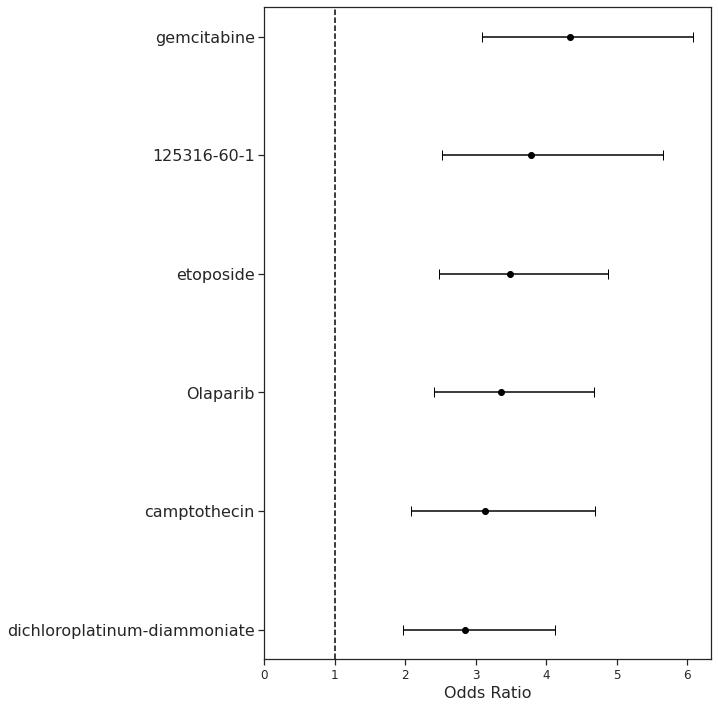

In [49]:
mtl_result, odds_fig = get_odds_ratio_mtl('models/Final', ont, dataset, task, drug_list, drug_name_map)

In [ ]:
odds_fig.savefig('../plots/mtl_odds.svg')

In [50]:
mtl_map = {'Drug':[r[1] for r in mtl_result], 'OR':[r[0] for r in mtl_result]}
mtl_df = pd.DataFrame(data=mtl_map)
mtl_df

,Drug,OR
0,dichloroplatinum-diammoniate,2.840550
1,camptothecin,3.122725
2,Olaparib,3.361111
3,etoposide,3.479660
4,125316-60-1,3.777822
5,gemcitabine,4.329762


In [54]:
performance_df = mtl_df.merge(vnn_df, on='Drug').merge(mlp_df, on='Drug')
performance_df.rename(columns={'OR_x':'Multi-task VNN', 'OR_y':'Single-task VNN', 'OR':'ANN'}, inplace=True)
performance_df

,Drug,Multi-task VNN,Single-task VNN,ANN
0,dichloroplatinum-diammoniate,2.840550,2.37947,1.866876
1,camptothecin,3.122725,2.325625,2.748615
2,Olaparib,3.361111,2.096704,1.443455
3,etoposide,3.479660,3.280883,2.461653
4,125316-60-1,3.777822,2.707899,2.938776
5,gemcitabine,4.329762,3.327246,1.91217


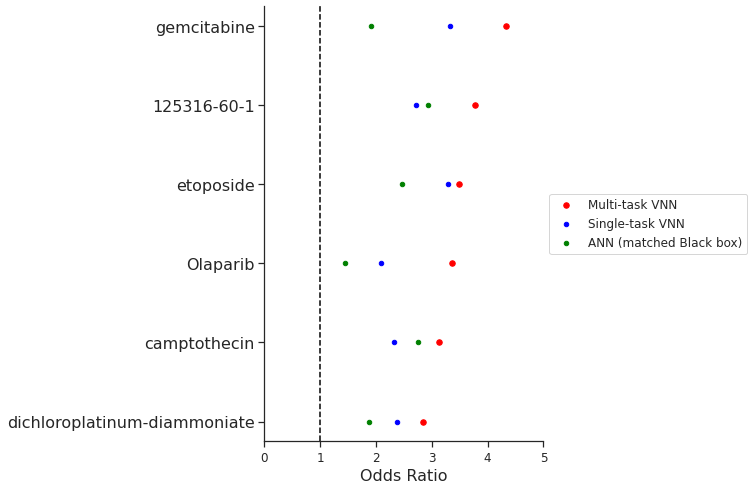

In [55]:
performance_df.columns = ['Drug', 'Multi-task VNN', 'Single-task VNN', 'ANN']
performance_df.sort_values(by=['Multi-task VNN'], inplace=True, ignore_index=True)

x_title = 'Odds Ratio'
y_title = ''
all_models_fig = all_models_scatterplot(performance_df, x_title, y_title)

In [56]:
all_models_fig.savefig('../plots/performance_comparison_odds_nn.svg')

In [ ]:
task = 'RS'
    
task_file='../data/training_files_' + dataset + '/task_list_' + task + '.txt'
drugs = read_file(task_file)

corr_list = get_avg_cv_data_mtl('models/Final', ont, dataset, task, drugs)
    
mtl_df = pd.DataFrame(np.transpose(corr_list), columns=['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5'])
mtl_df['Drug'] = [drug_name_map[d] for d in drugs]
mtl_df['Average'] = np.mean(np.transpose(corr_list), axis=1)
    
print(mtl_df)

In [ ]:
drugs = list(mtl_df['Drug'])

vnn_results_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    
    corr_list, avg_corr = get_avg_cv_data(ont, dataset, drug)
    
    vnn_results_df.loc[i]['Drug'] = drug
    vnn_results_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        vnn_results_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]
        
print(vnn_results_df)

In [ ]:
vnn_comp_fig = create_scatter_plot(list(vnn_results_df['Average']), list(mtl_df['Average']), 
                                   'Pearson Correlation (Single task)', 'Pearson Correlation (Multi task)')

In [ ]:
vnn_comp_fig.savefig('../plots/vnn_comparison_scatterplot_2022_09_19.svg')

In [ ]:
method = 'elastic_net'

elasticnet_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data_alternate(method, dataset, drug)
    print(drug, corr_list, avg_corr)
    
    elasticnet_df.loc[i]['Drug'] = drug
    elasticnet_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        elasticnet_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

In [ ]:
method = 'random_forest'

randomforest_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data_alternate(method, dataset, drug)
    print(drug, corr_list, avg_corr)
    
    randomforest_df.loc[i]['Drug'] = drug
    randomforest_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        randomforest_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

In [ ]:
method = 'mlp'

mlp_df = pd.DataFrame(index=range(len(drugs)), columns=['Drug', 'Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5', 'Average'])

for i, drug in enumerate(drugs):
    corr_list, avg_corr = get_avg_cv_data_alternate(method, dataset, drug)
    print(drug, corr_list, avg_corr)
    
    mlp_df.loc[i]['Drug'] = drug
    mlp_df.loc[i]['Average'] = avg_corr
    for k in range(5):
        mlp_df.loc[i]['Fold_'+str(k+1)] = corr_list[k]

In [ ]:
performance_df = pd.concat([mtl_df['Drug'], mtl_df['Average'], mlp_df['Average'], 
                            randomforest_df['Average'], elasticnet_df['Average']], axis=1, ignore_index=True)

performance_df.columns = ['Drug', 'MTL', 'Multi layer perceptron', 'Random Forest', 'ElasticNet']
performance_df.sort_values(by=['MTL'], inplace=True, ignore_index=True)

In [ ]:
x_title = 'Pearson Correlation'
y_title = 'Drug'
all_models_fig = all_models_scatterplot(performance_df, x_title, y_title)

In [ ]:
all_models_fig.savefig('../plots/performance_comparison_mtl.pdf')

In [ ]:
performance_df.columns = ['Drug', 'DCoDR', 'Multi layer perceptron', 'Random Forest', 'ElasticNet']

mlp = set()
rf = set()
eln = set()

for _,row in performance_df.iterrows():
    
    if row['DCoDR'] >= row['Multi layer perceptron']:
        mlp.add(row['Drug'])
        
    if row['DCoDR'] >= row['Random Forest']:
        rf.add(row['Drug'])
        
    if row['DCoDR'] >= row['ElasticNet']:
        eln.add(row['Drug'])
        
print('mlp', len(mlp))

print('rf', len(rf))

print('eln', len(eln))

print('all', len(mlp.intersection(rf).intersection(eln)))

print('total', len(performance_df))

In [ ]:
boxplot_df = pd.DataFrame({
    "Multi-task VNN": mtl_df['Average'],
    "NeST-VNN": vnn_results_df['Average'], 
    "ANN": mlp_df['Average'], 
    "RandomForest": randomforest_df['Average'], 
    "ElasticNet": elasticnet_df['Average']
})

In [ ]:
boxplot = get_boxplot(boxplot_df, "", "Pearson Correlation")

In [ ]:
boxplot.savefig('../plots/figure2/boxplot_comparison_May_09.svg')

In [ ]:
drugs = ['Palbociclib']
drug = 'Palbociclib'

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.grid(False)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.plot([0,1],[0,1], 'k--')
plt.ylabel("Sensitivity")
plt.xlabel("1 - Specificity")
plt.title('Palbociclib ROC Curves')

all_test_df = get_all_test(ont, dataset, zscore_method, drug, fold_size=5)
sens_df, res_df = stratify_data(all_test_df, 'auc')

all_test_df['true'] = 0
for i, row in all_test_df.iterrows():
    if str(row['cell_line']) in list(sens_df['cell_line']):
        all_test_df.at[i, 'true'] = -1
    elif str(row['cell_line']) in list(res_df['cell_line']):
        all_test_df.at[i, 'true'] = 1
    else:
        all_test_df.drop(i, inplace=True)

median = np.median(all_test_df['pred'])
mad = stats.median_abs_deviation(np.array(all_test_df['pred']), scale='normal')

fpr, tpr, threshold_res = metrics.roc_curve(all_test_df['true'], all_test_df['pred'])
print("AUC:", metrics.roc_auc_score(all_test_df['true'], all_test_df['pred']))
plt.plot(fpr, tpr, label='Predicted Drug Response')

med_i_res = 0
for i, t in enumerate(threshold_res):
    if t >= median:
        continue
    med_i_res = i
    break
plt.plot(fpr[med_i_res], tpr[med_i_res], marker='.', markersize=20)
plt.plot([fpr[med_i_res], fpr[med_i_res]], [0, tpr[med_i_res]], 'k-')
plt.plot([0, fpr[med_i_res]], [tpr[med_i_res], tpr[med_i_res]], 'k-')

std_i_res = 0
for i, t in enumerate(threshold_res):
    if t >= median + mad:
        continue
    std_i_res = i
    break
#std_i_res = np.where((tpr < 0.41) & (tpr > 0.39))[0][0]

plt.plot(fpr[std_i_res], tpr[std_i_res], marker='.', markersize=20)
plt.plot([fpr[std_i_res], fpr[std_i_res]], [0, tpr[std_i_res]], 'k-')
plt.plot([0, fpr[std_i_res]], [tpr[std_i_res], tpr[std_i_res]], 'k-')

ax.set_xticks(list(ax.get_xticks()) + [fpr[med_i_res], fpr[std_i_res]])
ax.set_yticks(list(ax.get_yticks()) + [tpr[med_i_res], tpr[std_i_res]])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#plt.show()1`

drugs = ['Palbociclib']
drug = 'Palbociclib'

#fig = plt.figure(figsize=(12, 12))
#ax = fig.add_subplot(111)
#ax.grid(False)
#ax.set_xlim([0,1])
#ax.set_ylim([0,1])
#plt.plot([0,1],[0,1], 'k--')
#plt.ylabel("Sensitivity")
#plt.xlabel("1 - Specificity")
#plt.title('ROC Curve')

all_test_df = get_all_test(ont, dataset, zscore_method, drug, fold_size=5)
sens_df, res_df = stratify_data(all_test_df, 'auc')
all_test_df['true'] = 0
for i, row in all_test_df.iterrows():
    if str(row['cell_line']) in list(sens_df['cell_line']):
        all_test_df.at[i, 'true'] = -1
    elif str(row['cell_line']) in list(res_df['cell_line']):
        all_test_df.at[i, 'true'] = 1
    else:
        all_test_df.drop(i, inplace=True)
median = np.median(all_test_df['pred'])
mad = stats.median_abs_deviation(np.array(all_test_df['pred']), scale='normal')
        
all_test_df['pred'] = all_test_df['pred'] * -1.0
all_test_df['true'] = all_test_df['true'] * -1
fpr, tpr, threshold_sens = metrics.roc_curve(all_test_df['true'], all_test_df['pred'])
print("AUC:", metrics.roc_auc_score(all_test_df['true'], all_test_df['pred']))
plt.plot(fpr, tpr, label='Predicted Drug Response')

med_i_sens = 0
median *= -1
for i, t in enumerate(threshold_sens):
    if t >= median:
        continue
    med_i_sens = i
    break
plt.plot(fpr[med_i_sens], tpr[med_i_sens], marker='.', markersize=20)
plt.plot([fpr[med_i_sens], fpr[med_i_sens]], [0, tpr[med_i_sens]], 'k-')
plt.plot([0, fpr[med_i_sens]], [tpr[med_i_sens], tpr[med_i_sens]], 'k-')

std_i_sens = 0
mad *= -1
for i, t in enumerate(threshold_sens):
    if t >= median - mad:
        continue
    std_i_sens = i
    break
#std_i_sens = np.where((tpr < 0.41) & (tpr > 0.39))[0][0]

plt.plot(fpr[std_i_sens], tpr[std_i_sens], marker='.', markersize=20)
plt.plot([fpr[std_i_sens], fpr[std_i_sens]], [0, tpr[std_i_sens]], 'k-')
plt.plot([0, fpr[std_i_sens]], [tpr[std_i_sens], tpr[std_i_sens]], 'k-')

ax.set_xticks(list(ax.get_xticks()) + [fpr[std_i_sens], fpr[med_i_sens]])
ax.set_yticks(list(ax.get_yticks()) + [tpr[std_i_sens], tpr[med_i_sens]])
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

In [ ]:
threshold_res[std_i_res]

In [ ]:
all_test_df['pred'] = all_test_df['pred'] * -1.0
all_test_df['true'] = all_test_df['true'] * -1

pred_list = sorted(all_test_df['pred'])

In [ ]:
t_high_idx = pred_list.index(threshold_res[std_i_res])
t_high_idx/len(all_test_df)

In [ ]:
t_low_idx = pred_list.index(threshold_sens[std_i_sens] * -1)
t_low_idx/len(all_test_df)

In [ ]:
fig.savefig('../plots/figure2/roc_curve_common_May_02.svg')